<span>
<img src="http://ndlib.readthedocs.io/en/latest/_static/ndlogo2.png" width="260px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.6<br/>
<b>NDlib version:</b>  4.0.1<br/>
<b>Last update:</b> 25/09/2018
</span>

<a id='top'></a>
# *Intro to NDlib: Network Diffusion library*

``NDlib`` is a python library designed to provide support to the analysis of diffusive phenomena occurring on top of complex network structures.

In this notebook are introduced some of the main features of the library and an overview of its functionalities.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started.

## Table of Contents

1. [Installing NDlib](#install)
2. [Simulation Workflow](#workflow)
    1. [Graph Creation](#graph)
    2. [Model Selection and Configuration](#model)
    3. [Simulation Execution](#simulation)
    4. [Results Visualisation](#visual)
3. [Available models](#models)
    1. [Epidemics](#epidemics)
    2. [Opinion Dynamics](#opinion)
4. [Advanced Model Configurations](#advanced)
    1. [Node Attributes](#nodes)
    2. [Edge Attributes](#edges)
    3. [Infection Seeds Selection](#seeds)
        1. [Model Stability](#stability)
        2. [Stability Visualisation](#stability_vis)
5. [Comparing Diffusion models](#comparing)
6. [Diffusion on Dynamic Networks](#dynamic)
    1. [DynetX: a library for dynamic network modeling](#dynetx)
        1. [Snapshot Graphs](#snapshots)
        2. [Interaction Networks](#interactions)
    2. [Available models](#models2)
    3. [Example: SIR](#dynsir)
7. [Custom Model Definition](#custom)
    1. [Compartments](#compartments)
        1. [Node compartments](#nc)
        2. [Edge compartments](#ec)
        3. [Time compartments](#tc)
    2. [Compartments Composition](#composition)
        1. [Cascading Composition](#cascading)
        2. [Conditional Composition](#conditional)
    3. [Example: SIR](#sir)
8. [NDQL: Network Diffusion Query Language](#ndql)
    1. [Syntax](#syntax)
    2. [Command line tools](#cmd)
    3. [Example: SIR](#sir2)
9. [Conclusions](#conclusion)

<a id='install'></a>
## 1. Installing NDlib ([to top](#top))

As a first step, we need to make sure that ``NDlib`` is installed and working.

The library is available for both python 2.7 and 3.x, and its stable version can be installed using ``pip``:

    pip install ndlib

On the project [GitHub](https://github.com/GiulioRossetti/ndlib) are also available the nightly builds that can be installed as follows:

    pip install git+https://github.com/GiulioRossetti/ndlib.git > /dev/null

In order to check if ``ndlib`` has been correctly installed just try to import it

In [1]:
import ndlib

<a id='workflow'></a>
## 2. Simulation Workflow ([to top](#top))

``Ndlib`` breaks the simulation of diffusive phenomena into a standard workflow:
- Network Creation
- Diffusion model Selection and Configuration
- Simulation execution
- Results visualisation

In this section we will observe how to templating such workflow describing a simple *SIR* simulation.

<img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/sir.png?raw=1"/>

<a id="graph"></a>
### 2.A Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``NDlib`` leverage [``networkx``](https://networkx.github.io) data structure to provide support for both directed and undirected graphs.

In this example, to perform our simulation, we instantiate a Erdos-Renyi graph as follows:

In [2]:
import networkx as nx

g = nx.erdos_renyi_graph(1000, 0.1)

<a id="model"></a>
### 2.B Model Selection and Configuration ([to top](#top))

After having defined the graph, we can select the diffusion model to simulate. In our example we import the SIR model and instantiate it on our graph.

In [12]:
import ndlib.models.epidemics as ep

model = ep.SEIRModel(g)

Every diffusion model has its own parameter, ``NDlib`` offers a common interface to specify them: ``ModelConfig``.
``ModelConfig`` takes care of validating model parameters.

Indeed, every model has its own parameters: model specific parameter list and definitions are available on the project [documentation site](http://ndlib.readthedocs.io).

In order to get a description of the required parameters just access the ``parameter`` field

In [13]:
import json
print(json.dumps(model.parameters, indent=2))

{
  "model": {
    "alpha": {
      "descr": "Incubation period",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "beta": {
      "descr": "Infection rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "gamma": {
      "descr": "Recovery rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "tp_rate": {
      "descr": "Whether if the infection rate depends on the number of infected neighbors",
      "range": [
        0,
        1
      ],
      "optional": true,
      "default": 1
    }
  },
  "nodes": {},
  "edges": {}
}


Similarly, to obtain a list of the statuses implemented in the selected model just access the ``available_statuses`` field

In [5]:
model.available_statuses

{'Susceptible': 0, 'Infected': 1, 'Removed': 2}

In [6]:
import ndlib.models.ModelConfig as mc

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) # infection rate
cfg.add_model_parameter('gamma', 0.01) # recovery rate

``ModelConfig`` also allows to describe the initial condition of the simulation. It makes possible, for instance, to specify the initial percentage of infected nodes in the network.

<a id="simulation"></a>
### 2.C Simulation Execution ([to top](#top))

Once described the network, the model and the initial conditions it is possible to perform the simulation.

``NDlib`` models diffusive phenomena as **discrete-time**, **agent-based** processes: during every iteration all nodes are evaluated and, their statuses are updated accordingly to the model rules.

Iterations can be required (incrementally) by using two methods:
- ``iteration()``
- ``iteration_bunch(nbunch, node_status=False)``

The former computes a single iteration step, the latter executes ``nbunch`` iterations. 

The ``node_status`` parameter allows to return the individual node status at each iteration.

In [8]:
iterations = model.iteration_bunch(200, node_status=True)
iterations

100%|██████████| 200/200 [00:02<00:00, 79.07it/s]


,
   763: 1,
   850: 1,
   861: 1,
   886: 1},
  'node_count': {0: 119, 1: 680, 2: 201},
  'status_delta': {0: -13, 1: 10, 2: 3}},
 {'iteration': 79,
  'status': {128: 1,
   181: 2,
   204: 2,
   212: 1,
   213: 2,
   387: 1,
   432: 2,
   488: 1,
   586: 1,
   688: 1,
   721: 2,
   836: 1,
   962: 1},
  'node_count': {0: 111, 1: 683, 2: 206},
  'status_delta': {0: -8, 1: 3, 2: 5}},
 {'iteration': 80,
  'status': {145: 1,
   150: 2,
   177: 1,
   257: 2,
   315: 2,
   336: 1,
   643: 2,
   911: 2,
   922: 1},
  'node_count': {0: 107, 1: 682, 2: 211},
  'status_delta': {0: -4, 1: -1, 2: 5}},
 {'iteration': 81,
  'status': {42: 2,
   123: 2,
   135: 1,
   139: 2,
   246: 2,
   465: 1,
   509: 1,
   601: 2,
   659: 2,
   714: 1,
   846: 2,
   886: 2,
   899: 1,
   947: 1},
  'node_count': {0: 101, 1: 680, 2: 219},
  'status_delta': {0: -6, 1: -2, 2: 8}},
 {'iteration': 82,
  'status': {78: 2,
   96: 1,
   187: 1,
   235: 1,
   308: 2,
   389: 2,
   410: 2,
   412: 2,
   424: 1,
   431: 1,

To abstract from iterations details it is possible to transform them into diffusion **trends** using the ``build_trends(iterations)`` method:

In [9]:
trends = model.build_trends(iterations)
trends

[{'trends': {'node_count': {0: [990,
     990,
     987,
     987,
     987,
     987,
     985,
     983,
     983,
     982,
     980,
     977,
     975,
     972,
     968,
     964,
     960,
     960,
     957,
     954,
     952,
     948,
     938,
     932,
     927,
     923,
     921,
     917,
     911,
     902,
     893,
     883,
     876,
     864,
     848,
     836,
     827,
     816,
     800,
     787,
     770,
     757,
     739,
     722,
     706,
     681,
     656,
     637,
     617,
     583,
     557,
     533,
     513,
     492,
     478,
     454,
     437,
     418,
     389,
     372,
     357,
     341,
     329,
     310,
     293,
     274,
     262,
     242,
     227,
     216,
     207,
     193,
     180,
     173,
     164,
     150,
     139,
     132,
     119,
     111,
     107,
     101,
     95,
     88,
     87,
     82,
     79,
     76,
     75,
     65,
     60,
     56,
     52,
     51,
     45,
     42,
     42,
     38,
     37,


<a id="top"></a>
###  2.D Results Visualisation ([to top](#top))

Finally, ``NDlib`` allows to inspect the behavior of the simulated model using standard plots such as the ``DiffusionTrend`` and ``DiffusionPrevalence`` ones.

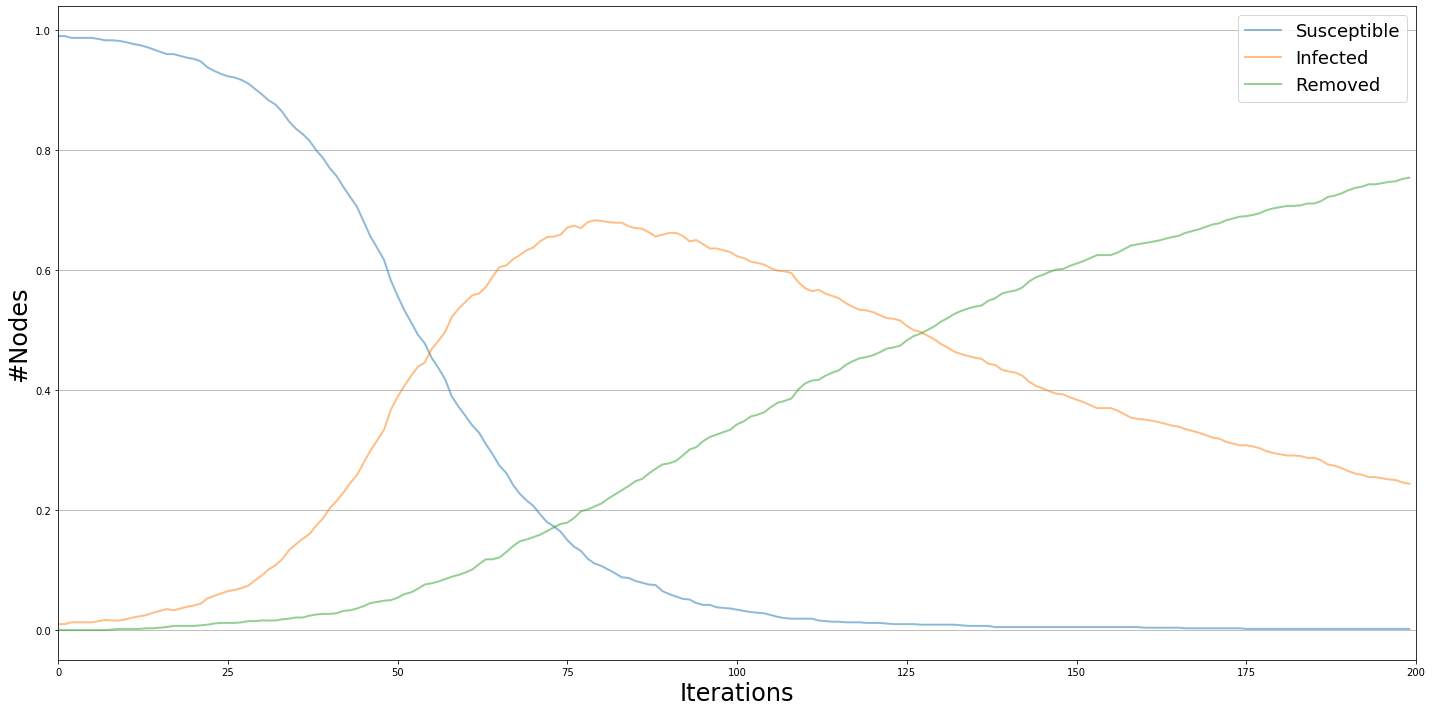

In [10]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
viz.plot()

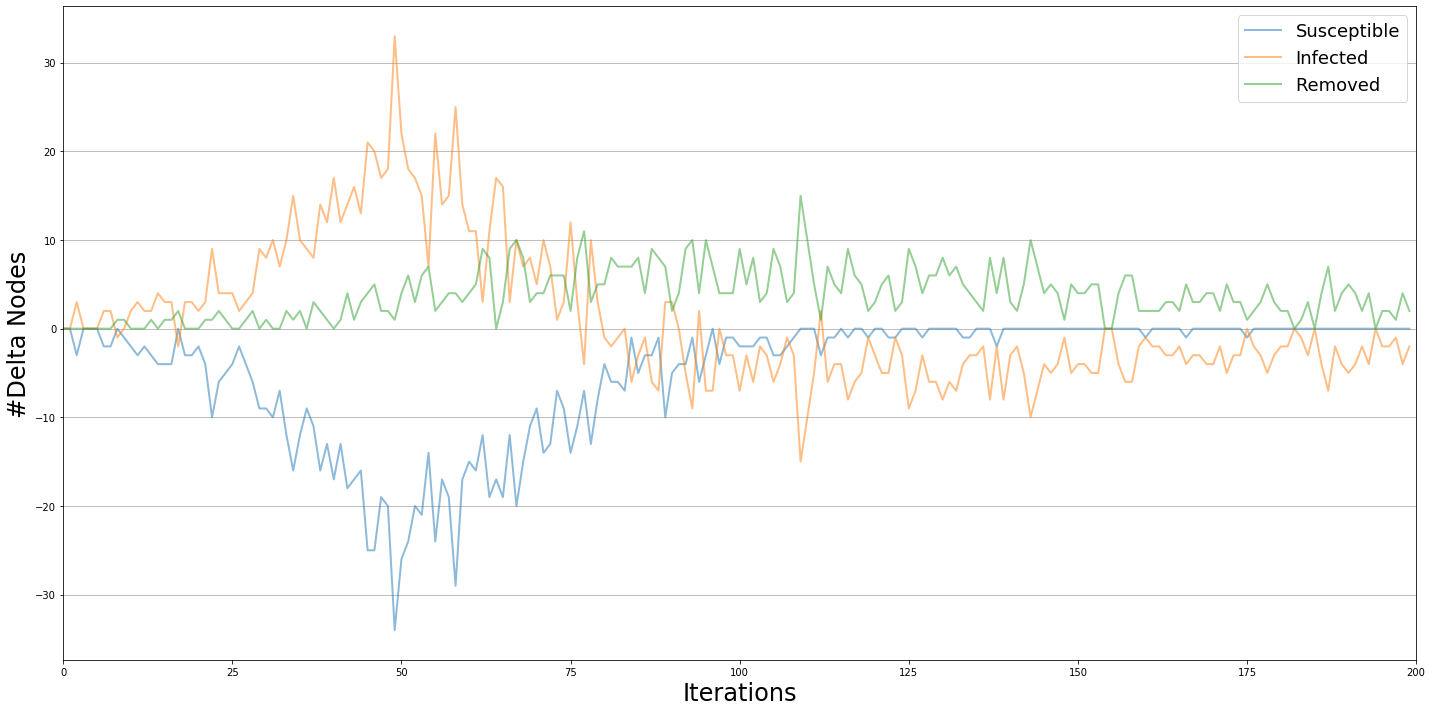

In [11]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()

The proposed visualisation are realised using the [``matplotlib``](https://matplotlib.org) python library. They are fully customizable and all the metadata they visualize is gathered by the ``model`` object.

To obtain web-oriented versions of such plots ``NDlib`` exposes a second visualisation endpoint built on top of [``bokeh``](https://bokeh.pydata.org/en/latest/): the plotting facilities its defines are collected within the sub-package ``ndlib.viz.bokeh`` and follow the same rationale of their ``matplotlib`` counterpart.

<a id="models"></a>
## 3. Available models ([to top](#top))

The analysis of diffusive phenomena that unfold on top of complex networks is a task able to attract growing interests from multiple fields of research.

In order to provide a succinct framing of such complex and extensively studied problem it is possible to split the related literature into two broad, related, sub-classes: **Epidemics** and **Opinion Dynamics**.

<a id="epidemics"></a>
### 3.A Epidemics ([to top](#top))

When we talk about epidemics, we think about contagious diseases caused by biological pathogens, like influenza, measles, chickenpox and sexually transmitted viruses that spread from person to person. 

Several elements determine the patterns by which epidemics spread through groups of people: the properties carried by the pathogen (its contagiousness, the length of its infectious period and its severity), the structure of the network as well as the mobility patterns of the people involved. 

In ``NDlib`` are implemented the following 12 Epidemic models:

<table>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIm.html'>SI</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIS.html'>SIS</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html'>SIR</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SEIR.html'>SEIR</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SEIS.html'>SEIS</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SWIR.html'>SWIR</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html'>Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/GeneralisedThreshold.html'>Generalised Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/KThreshold.html'>Kertesz Threshold</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Profile.html'>Profile</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/ProfileThreshold.html'>Profile-Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/IndependentCascades.html'>Independent Cascades</a></td>
    </tr>
</table>

<a id="opinions"></a>
### 3.B Opinion Dynamics ([to top](#top))

A different field related with modelling social behaviour is that of opinion dynamics.

Recent years have witnessed the introduction of a wide range of models that attempt to explain how opinions form in a population, taking into account various social theories (e.g. bounded confidence or social impact).

These models have a lot in common with those seen in epidemics and spreading. In general, individuals are modelled as agents with a state and connected by a social network.

The social links can be represented by a complete graph (*mean field* models) or by more realistic complex networks, similar to epidemics and spreading.

The state is typically represented by variables, that can be *discrete* (similar to the case of spreading), but also *continuous*, representing for instance a probability to choose one option or another. The state of individuals changes in time, based on a set of update rules, mainly through interaction with the neighbours.

While in many spreading and epidemics models this change is irreversible (susceptible to infected), in opinion dynamics the state can oscillate freely between the possible values, simulating thus how opinions change in reality.

In ``NDlib`` are implemented the following 6 Opinion Dynamics models:

<table>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/Voter.html'>Voter</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/QVoter.html'>Q-Voter</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/MajorityRule.html'>Majority Rule</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/Snajzd.html'>Sznajd</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/COD.html'>Cognitive Opinion Dynamics</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/AlgorithmicBias.html'>Algorithmic Bias</a></td>
    </tr>
</table>

<a id="advanced"></a>
## 4 Advanced Model Configurations ([to top](#top))

As already discussed, the ``ModelConfig`` object is the common interface ``NDlib`` use to set up simulation experiments.

``ModelConfig`` allows to specify four categories of experiment configurations:
- **Model** configuration (as already discussed)
- **Node** Configuration
- **Edge** Configuration
- Simulation **Initial Conditions**

<a id="nodes"></a>
### 4.A Node Attributes ([to top](#top))

Node configuration involves the instantiation of both the *mandatory* and *optional* parameters attached to individual nodes.

Let's consider as an example the ``Threshold`` model. 

In such model a *susceptible* node in order to become *infected* needs that at least $\tau\%$ of its neighbors are already *infected*. 

We can assign a value of $\tau\%$ to every node as follows:

In [ ]:
model = ep.ThresholdModel(g)

config = mc.Configuration()
config.add_model_parameter('percentage_infected', 0.1)

threshold = 0.25
for i in g.nodes():
    config.add_node_configuration("threshold", i, threshold) # node attribute setting

model.set_initial_status(config)

<a id="edges"></a>
### 4.B Edge Attributes ([to top](#top)) 

Edge configuration involves the instantiation of both the *mandatory* and *optional* parameters attached to individual edges.

Let's consider as an example the ``IndependentCascades`` model. 

In such model a *susceptible* node become *infected* with probability $p$, where $p$ is a value attached to the link connecting the *susceptible* node to an *infected* neighbor.

We can assign a value of $p$ to every edge as follows:

In [ ]:
model = ep.IndependentCascadesModel(g)

config = mc.Configuration()
config.add_model_parameter('percentage_infected', 0.1)

threshold = 0.1
for e in g.edges():
    config.add_edge_configuration("threshold", e, threshold) # edge attribute setting

model.set_initial_status(config)

<a id="seeds"></a>
### 4.C Infection Seeds Selection ([to top](#top))

Status configuration allows to specify explicitly the status of a set of nodes at the beginning of the simulation.

So far we have assumed that a random sample of nodes (10% in our examples) were initially infected: in order to cover more specific simulation scenarios we can also explicitly *specify* the nodes belonging to each *status* at the beginning of the simulation.

In [ ]:
import ndlib.models.ModelConfig as mc

# Model Configuration
config = mc.Configuration()

infected_nodes = [0, 1, 2, 3, 4, 5]
config.add_model_initial_configuration("Infected", infected_nodes)

**NB:** Explicit status specification takes priority over the percentage specification expressed via model definition (e.g. percentage_infected).

<a id="stability"></a>
#### 4.C.a Model Stability ([to top](#top))

Indeed, different initial conditions can affect the overall unfolding of the diffusive process.

In order to analyse the stability of a model w.r.t. the initial seeds ``NDlib`` implements a ``multi_runs`` facility.

``multi_runs`` allows the parallel execution of multiple instances of a given model starting from different initial infection conditions.

We can instantiate ``multi_runs`` as follows:

In [ ]:
from ndlib.utils import multi_runs
import warnings
warnings.filterwarnings("ignore")

model = ep.SIRModel(g)
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("percentage_infected", 0.05)
model.set_initial_status(config)

trends = multi_runs(model, execution_number=10, iteration_number=100, nprocesses=4)

In our example the initial seeds for each instance of the model were specified by the ``percentage_infected`` model parameter.

Indeed we can also explicitly parametrize the seed sets as follows:

In [ ]:
model = ep.SIRModel(g)

config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
model.set_initial_status(config)

infection_sets = [(1, 2, 3, 4, 5), (3, 23, 22, 54, 2), (98, 2, 12, 26, 3), (4, 6, 9) ]
trends1 = multi_runs(model, execution_number=4, iteration_number=100, infection_sets=infection_sets, nprocesses=4)

<a id="stability_vis"></a>
#### 4.C.b Stability Visualisation ([to top](#top))

Model stability can be easily analised by using the visualisation facilities offered by the library: both ``DiffusionTrend`` and ``DiffusionPrevalence`` plots allows to plot mean trends along with their point-wise variation.

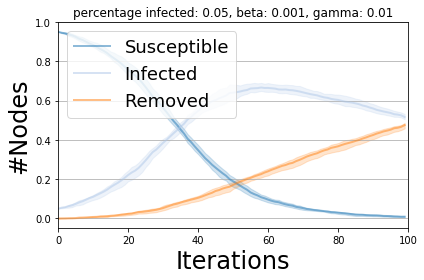

In [ ]:
viz = DiffusionTrend(model, trends)
viz.plot(percentile=90)

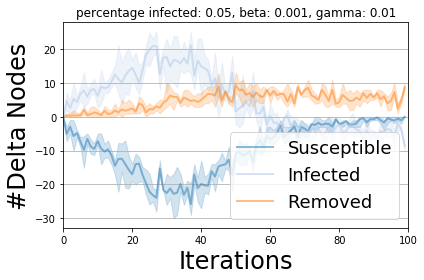

In [ ]:
viz = DiffusionPrevalence(model, trends)
viz.plot(percentile=90)

<a id="comparing"></a>
## 5. Comparing Diffusion models ([to top](#top))

A common goal for which diffusion simulations are executed is to perform comparison among different models (or different instantiations of a same model).

To address such demands ``NDlib`` provides visual comparison plots.

To show how they work, as a first step we execute a second model (in this exampe an **SI** model) over our original graph.

In [ ]:
model1 = ep.SIModel(g)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001)
cfg.add_model_parameter("percentage_infected", 0.01)
model1.set_initial_status(cfg)

trends1 = multi_runs(model1, execution_number=10, iteration_number=100, nprocesses=4)

Then, we can compare them:

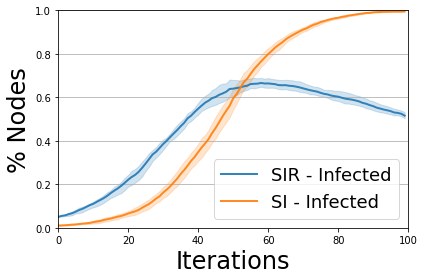

In [ ]:
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
viz = DiffusionTrendComparison([model, model1], [trends, trends1], statuses=['Infected'])
viz.plot()

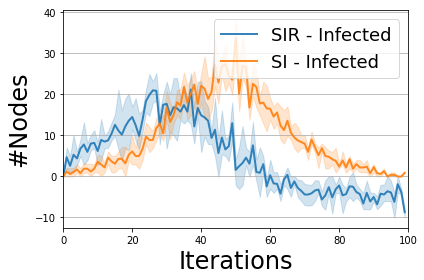

In [ ]:
from ndlib.viz.mpl.PrevalenceComparison import DiffusionPrevalenceComparison
viz = DiffusionPrevalenceComparison([model, model1], [trends, trends1], statuses=['Infected'])
viz.plot()

The method parameter ``statuses`` takes as input a list of the models statuses trends we want to compare.
So, for instance, if we are interested in comparing both the trends for *Infected* and *Susceptible* nodes we can do something like this:

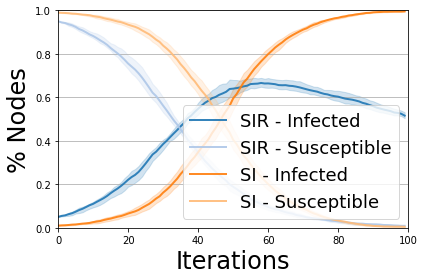

In [ ]:
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
viz = DiffusionTrendComparison([model, model1], [trends, trends1], statuses=['Infected', 'Susceptible'])
viz.plot()

<a id="dynamic"></a>
## 6. Diffusion on Dynamic Networks ([to top](#top))

So far we assumed that a *static* network topology. In real world scenario it is likely to observe nodes (as well as edges) that appear and desapear as time goes by, deeply affecting network structure and connectivity.

Indeed, topological transformations have huge implications on how diffusive phenomena unfold. 

``NDlib`` leverages [``DyNetx``](http://dynetx.readthedocs.io/en/latest/) to model time-evolving graphs. In the following we briefly introduce some [``DyNetx``](http://dynetx.readthedocs.io/en/latest/) primitives that allows to build and analyse dynamic networks.

A dynamic network is a topology having timestamps attached to edges (and/or nodes). As an example:


<img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/rete.png?raw=1" width="50%" align="center"/>

<a id="dynetx"></a>
### 6.A DyNetX: a library for dynamic network modeling ([to top](#top))

[``DyNetx``](http://dynetx.readthedocs.io/en/latest/) is a Python software package that extends [``networkx``](https://networkx.github.io) with dynamic network models and algorithms.

We developed [``DyNetx``](http://dynetx.readthedocs.io/en/latest/) as a support library for ``NDlib``. It provides a generic implementation of dynamic network topology that can be used to model directed/undirected
- [Snapshot Graphs](#snapshots)
- [Interaction Networks](#interactions)

In [``DyNetx``](http://dynetx.readthedocs.io/en/latest/) a generic dynamic graph can be built using:

In [ ]:
import dynetx as dn

g = dn.DynGraph() # empty dynamic graph

g.add_interaction(u=1, v=2, t=0, e=2) # adding the edge (1,2) at t=0 that vanishes at time e=2
g.add_interactions_from([(1, 4), (2, 5), (3, 1)], t=1) # adding some edges at time t=1
g.add_interactions_from([(2, 6), (3, 2)], t=2) # adding some edges at time t=2
g.add_interactions_from([(1, 5)], t=3) # adding some edges at time t=3

<a id="snapshots"></a>
#### 6.A.a Snapshot Graphs ([to top](#top))

Often, network history is partitioned into a series of snap- shots, each one of them corresponding either to the state of the network at a time $t$ or to the aggregation of observed interactions during a period. Formally,

> A ``Snapshot Graph`` $G_t$ is defined by a temporally ordered set $⟨G_1, G_2\dots G_t⟩$ of static graphs where each snapshot $G_i = (V_i, E_i)$ is univocally identified by the sets of nodes $V_i$ and edges $E_i$.

Network snapshots can be effectively used, for instance, to model a phenomenon that generates network perturbations (almost) at regular intervals. In this scenario, context-dependent temporal windows are used to partition the network history into consecutive snapshots: time-bounded observations describing a precise, static, discretization of the network life.

Considering our dynamic network example we can identify the following snapshot graphs:

<img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/ex1.png?raw=1" width="35%" align="left"/><img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/ex2.png?raw=1" width="25%" align="left"/><img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/ex3.png?raw=1" width="35%" align="left"/>

[``DyNetx``](http://dynetx.readthedocs.io/en/latest/) allows to (among the other things):
- List the snapshots of the loaded graph

In [ ]:
g.temporal_snapshots_ids()

[0, 1, 2, 3]

- Access a specific snapshot

In [ ]:
g1 = g.time_slice(1)
g1.edges()

EdgeView([(1, 2), (1, 4), (1, 3), (2, 5)])

Moreover, snapshot graphs can also be read from/wite to file. For additional details refer to the official [documentation](http://dynetx.readthedocs.io/en/latest/index.html).

<a id="interactions"></a>
#### 6.A.b Interaction networks ([to top](#top))

An ``Interaction network`` models a dynamic structure in which both nodes and edges may appear and disappear as time goes by. Usually, ``Intercation network`` are used in absence of a clear aggregation time scale, or when make sense to analyse a dynamic networok as a continuos stream of edges. Formally,

> An ``interaction network`` is a graph $G = (V, E, T)$ where: $V$ is a set of triplets of the form $(v, t_s, t_e)$, with $v$ a vertex of the graph and $t_s$, $t_e \in T$ are respectively the birth and death timestamps of the corresponding vertex (with $t_s \leq t_e$); $E$ is a set of quadruplets $(u, v, t_s, t_e)$, with $u, v \in V$ are vertices of the graph and $t_s,t_e \in T$ are respectively the birth and death timestamps of the corresponding edge (with $t_s \leq t_e$).

Considering our dynamic network example we can identify the following interaction stream:

<img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/ex4.png?raw=1"  />

[``DyNetx``](http://dynetx.readthedocs.io/en/latest/) allows to to obtain the edge stream of a given dynamic graph.

In [ ]:
for i in g.stream_interactions():
    print(i)

(1, 2, '+', 0)
(1, 4, '+', 1)
(2, 5, '+', 1)
(3, 1, '+', 1)
(1, 2, '-', 2)
(2, 6, '+', 2)
(3, 2, '+', 2)
(1, 5, '+', 3)


In the former representation: 
- the first two values identify the nodes involved in an edge
- the third value identify the edge operation ('+' apparence, '-' vanishing)
- the last value identify the timestamp

Also ``interaction networks`` can be read from/wite to file. For additional details refer to the official [documentation](http://dynetx.readthedocs.io/en/latest/index.html).

<a id="models2"></a>
### 6.B Available models ([to top](#top))

As we have discussed, network topology may evolve as time goes by.

In order to automatically leverage network dynamics ``NDlib`` enables the definition of diffusion models that work on ``Snapshot Graphs`` as well as on ``Interaction Networks``.

In particular, so far, ``NDlib`` implements dynamic network versions of the following epidemic models:

<table>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/dynamics/dSI.html'>SI</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/dynamics/dSIS.html'>SIS</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/dynamics/dSIR.html'>SIR</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/dynamics/dProfile.html'>Profile</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/dynamics/dProfileThreshold.html'>Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/dynamics/dKThreshold.html'>Kertesz Threshold</a></td>
    </tr>
</table>

<a id="dynsir"></a>
### 6.C Example: SIR ([to top](#top))

Let's instantiate a revised SIR model on a dynamic netework, first on ``snapshot graphs``...

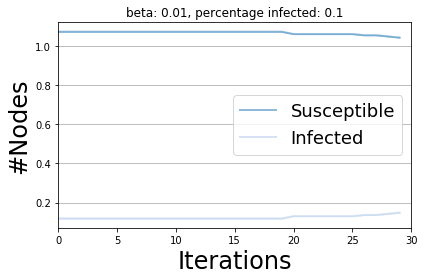

In [ ]:
import ndlib.models.dynamic as dm

# Dynamic Network topology
dg = dn.DynGraph()

# Naive synthetic dynamic graph 
# At each timestep t a new graph having the same set of node ids is created
for t in range(0, 30):
    g = nx.erdos_renyi_graph(200, 0.01)
    dg.add_interactions_from(g.edges(), t)

# Model selection
model = dm.DynSIModel(dg)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.01)
config.add_model_parameter("percentage_infected", 0.1)
model.set_initial_status(config)

# Simulate snapshot based execution
iterations = model.execute_snapshots()
trends = model.build_trends(iterations)

viz = DiffusionTrend(model, trends)
viz.plot()

then in ``interaction networks``

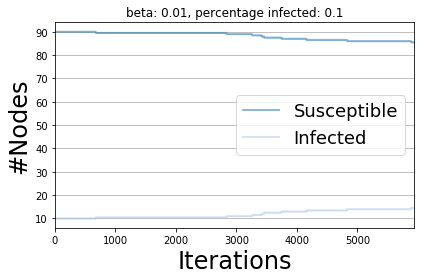

In [ ]:
model = dm.DynSIModel(dg)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.01)
config.add_model_parameter("percentage_infected", 0.1)
model.set_initial_status(config)

# Simulation interaction graph based execution
iterations = model.execute_iterations()
trends = model.build_trends(iterations)

viz = DiffusionTrend(model, trends)
viz.plot()

We can easily observe that the model we adopt to describe network dynamics (``snapshot graphs`` or ``interaction networks``) deeply affects the unfolding of a same diffusive process over a given evolving graph.

<a id="custom"></a>
## 7. Custom Model Definition ([to top](#top))

``NDlib`` comes with a handy syntax for compositional (custom) model definition to support its users in designing novel diffusion models.

At a higher level of abstraction a generic diffusion process can be described by two components:

1. The nodes' ``statuses`` it exposes, and
2. the ``transition rules`` that regulate status changes.

We recall that all models of ``NDlib`` assume an agent-based, discrete-time, simulation engine. 

During each iteration all the nodes in the network are asked to 
1. evaluate their current status and to 
2. (eventually) apply a matching transition rule. 

A generic ``transition rule`` can be expressed with something like:

> **if** ``actual_node_status`` **and** ``condition`` **then** ``new_node_status``

The ``condition`` can be easily decomposed into the evaluation of atomic operations that we will call ``compartments``. The evaluation of a compartment can return either ``True`` (condition satisfied) or ``False`` (condition not satisfied).

A simple ``condition`` is composed by a single ``compartment``.

Indeed, several ``compartments`` can be described, each one of them capturing an atomic operation.

A custom model, having three statuses (``Susceptible``, ``Infected``, ``Recovered``), can be instantiated as follows:

In [ ]:
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments.NodeStochastic as ns

# Composite Model instantiation
model = gc.CompositeModel(g)
model.add_status("Susceptible")
model.add_status("Infected")
model.add_status("Recovered")

<a id="compartments"></a>
### 7.A Compartments ([to top](#top))

> *Which are the atomic conditions that can be used to define complex transition rules?*

To answer such question we identified three families of ``compartments`` (and some operations to combine them).

<a id="nc"></a>
#### 7.A.a Node Compartments ([to top](#top))
In this class fall all those compartments that evaluate conditions tied to node status/features. They model stochastic events as well as deterministic ones.

<table>
    <tr><td><b>Name</b></td><td><b>Use case</b></td><tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/NodeStochastic.html'>Node Stochastic</a></td>
        <td>Consider a rule that requires a <b>probability</b> $\beta$ to be satisfied. </td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/NodeCategoricalAttribute.html'>Node Categorical Attribute</a></td>
        <td>Consider a rule that requires a specific value of a <b>categorical</b> node attribute to be satisfied (e.g. “Sex”=”male”).</td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/NodeNumericalAttribute.html'>Node Numerical Attribute</a></td>
        <td>Consider a rule that requires a specific value of a <b>numerical</b> node attribute to be satisfied (e.g. “Age” >= 18).</td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/NodeThreshold.html'>Node Threshold</a></td>
        <td>Consider a rule that requires that, at least, a <b>percentage</b> $\beta$ of Infected neighbors for a node to be satisfied.</td>
    </tr>
</table>

Let's add to our model a rule employing a node stochastic compartment:

In [ ]:
import ndlib.models.compartments.NodeStochastic as ns

# Compartment description
c1 = ns.NodeStochastic(0.02, triggering_status="Infected")

# Rule definition
model.add_rule("Susceptible", "Infected", c1)

The **Susceptble -> Infected** rule defined works as follows:
- if a node $n$ is *susceptible*, and
- if $n$ has at least an *infected* neighbor (``triggering_status``)
- then, with probability $0.02$, $n$ status will shift to *infected*

<a id="ec"></a>
#### 7.A.b Edge Compartments ([to top](#top))
In this class fall all those compartments that evaluate conditions tied to edge features. They model stochastic events as well as deterministic ones.


<table>
    <tr><td><b>Name</b></td><td><b>Use case</b></td><tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/EdgeStochastic.html'>Edge Stochastic</a></td>
        <td>Consider a rule tha requires a direct link among an infected node and a susceptible one and that is subject to a <b>probability</b> $\beta$ tied to such edge.</td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/EdgeCategoricalAttribute.html'>Edge Categorical Attribute</a></td>
        <td>Consider a rule tha requires a link among an infected node and a susceptible one that has a specific <b>categorical</b> value (e.g. “type”=”co-worker”)</td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/EdgeNumericalAttribute.html'>Edge Numerical Attribute</a></td>
        <td>Consider a rule tha requires a link among an infected node and a susceptible one that has a specific <b>numerical</b> value (e.g. “weight”<3)</td>
    </tr>  
</table>

Let's add to our model a rule employing an edge stochastic compartment:

In [ ]:
import ndlib.models.compartments.EdgeStochastic as es

c2 = es.EdgeStochastic(0.02, triggering_status="Recovered")

# Rule definition
model.add_rule("Infected", "Recovered", c2)

The **Infected -> Recovered** rule defined works as follows:
- if a node $n$ is *infected*, and
- let $\Gamma$ be the set containing the *recovered* (``triggering_status``) neighbors of $n$
    - then for each node $v\in \Gamma$ with probability $0.02$, $n$ status will shift to *recovered*

<a id="tc"></a>
#### 7.A.c Time Compartments ([to top](#top))
In this class fall all those compartments that evaluate conditions tied to temporal execution. They can be used to model, for instance, lagged events as well as triggered transitions.

<table>
    <tr><td><b>Name</b></td><td><b>Use case</b></td><tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/custom/compartments/CountDown.html'>Count Down</a></td>
        <td>Consider a rule that has an <b>incubation</b> period of $t$ iterations.</td>
    </tr>
</table>


Let's add to our model a rule employing a count down compartment

In [ ]:
import ndlib.models.compartments.CountDown as cd

c3 = cd.CountDown("incubation", iterations=10)

# Rule definition
model.add_rule("Recovered", "Susceptible", c1)

The **Recovered -> Susceptible** rule defined works as follows:
- if a node $n$ is *recovered* a count down named ``incubation`` is instantiated
- during each iteration ``incubation`` is decremented
- when ``incubation=0`` $n$ shifts to *susceptible*

<a id="composition"></a>
### 7.B Compartments Composition ([to top](#top))

Compartment can be chained in multiple ways so to describe complex transition rules. 

In particular, a transition rule can be seen as a tree whose nodes are compartments and edges connections among them.

As an example consider the following picture describing the structure of a composite **Susceptible->Infected** transition rule.

<img src="https://github.com/KDDComplexNetworkAnalysis/CNA_Tutorials/blob/master/img/rule.png?raw=1"/>

- The initial node status is evaluated at the root of the tree (the master compartment)
    - If the operation described by such compartment is satisfied the conditions of (one of) its child compartments is evaluated
    - If a path from the root to one leaf of the tree is completely satisfied the transition rule applies and the node change its status.

Compartments can be combined following two criteria:

- Cascading Composition
- Conditional Composition

A ``transition rule`` can be defined by employing all possible combinations of cascading and conditional compartment composition.

<a id="cascading"></a>
### 7.B.a Cascading Composition ([to top](#top))

Since each compartment identifies an atomic condition it is natural to imagine rules described as chains of compartments.

A compartment chain identify and ordered set of conditions that needs to be satisfied to allow status transition (it allows describing an **AND** logic).

To implement such behaviour each compartment exposes a parameter (named ``composed``) that allows to specify the subsequent compartment to evaluate in case it condition is satisfied.

#### Example

In the following scenario the **Susceptible->Infected** rule is implemented using three NodeStochastic compartments chained as follows:

$$C_1 \rightarrow C_2 \rightarrow C_3$$

- If the node $n$ is *Susceptible*
 - $C_1$: if at least a neighbor of the actual node is *Infected*, with probability $0.5$ evaluate compartment $C_2$
 - $C_2$: with probability $0.4$ evaluate compartment $C_3$
 - $C_3$: with probability $0.2$ allow the transition to the *Infected* state

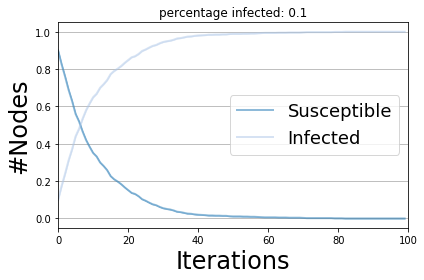

In [ ]:
# Network generation
g = nx.erdos_renyi_graph(1000, 0.1)

# Composite Model instantiation
model = gc.CompositeModel(g)

# Model statuses
model.add_status("Susceptible")
model.add_status("Infected")

# Compartment definition and chain construction
c3 = ns.NodeStochastic(0.2)
c2 = ns.NodeStochastic(0.4, composed=c3)
c1 = ns.NodeStochastic(0.5, "Infected", composed=c2)

# Rule definition
model.add_rule("Susceptible", "Infected", c1)

# Model initial status configuration
config = mc.Configuration()
config.add_model_parameter('percentage_infected', 0.1)

# Simulation execution
model.set_initial_status(config)
iterations = model.iteration_bunch(100)

trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()

<a id="conditional"></a>
### 7.B.a Conditional Composition ([to top](#top))

Conditional compartment composition allows to describe rules as trees.

A compartment tree identify and ordered and disjoint set of conditions that needs to be satisfied to allow status transition (it allows describing an **OR** logic).

``ConditionalComposition`` compartment allows to describe branching pattern as follows:

$$if\ C_i then\ C_j else\ C_z$$

``ConditionalComposition`` evaluate the guard compartment ($C_i$) and, depending from the result it gets (True or False) move to the evaluation of one of its two child compartments ($C_j$ and $C_z$).

#### Example

In the following scenario the **Susceptible->Infected** rule is implemented using three NodeStochastic compartments combined as follows:

- If the node $n$ is *Susceptible*
    - $C_1$: if at least a neighbor of the actual node is *Infected*, with probability $0.5$ evaluate compartment $C_2$ else evaluate compartment $C_3$
        - $C_2$: with probability $0.2$ allow the transition to the *Infected* state
        - $C_3$: with probability $0.1$ allow the transition to the *Infected* state


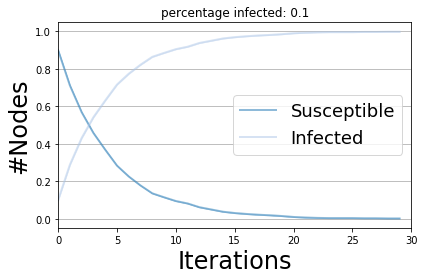

In [ ]:
import ndlib.models.compartments.ConditionalComposition as cif

# Network generation
g = nx.erdos_renyi_graph(1000, 0.1)

# Composite Model instantiation
model = gc.CompositeModel(g)

# Model statuses
model.add_status("Susceptible")
model.add_status("Infected")

# Compartment definition
c1 = ns.NodeStochastic(0.5, "Infected")
c2 = ns.NodeStochastic(0.2)
c3 = ns.NodeStochastic(0.1)

# Conditional Composition
cc = cif.ConditionalComposition(c1, c2, c3)

# Rule definition
model.add_rule("Susceptible", "Infected", cc)

# Model initial status configuration
config = mc.Configuration()
config.add_model_parameter('percentage_infected', 0.1)

# Simulation execution
model.set_initial_status(config)
iterations = model.iteration_bunch(30)
trends = model.build_trends(iterations)

viz = DiffusionTrend(model, trends)
viz.plot()

<a id="sir"></a>
### 7.C Example: SIR ([to top](#top)) 

Let's describe, and simulate, a **SIR** model using compartments.

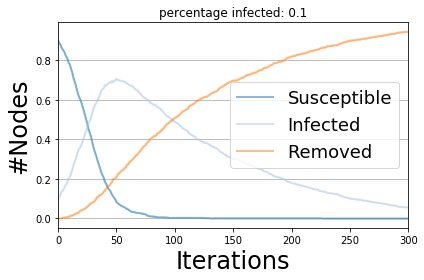

In [ ]:
from ndlib.models.CompositeModel import CompositeModel
from ndlib.models.compartments.NodeStochastic import NodeStochastic

# Network definition
g1 = nx.erdos_renyi_graph(n=1000, p=0.1)

# Model definition
SIR = CompositeModel(g1)
SIR.add_status('Susceptible')
SIR.add_status('Infected')
SIR.add_status('Removed')

# Compartments
c1 = NodeStochastic(triggering_status='Infected', rate=0.001, probability=1)
c2 = NodeStochastic(rate=0.01, probability=1)

# Rules
SIR.add_rule('Susceptible', 'Infected', c1)
SIR.add_rule('Infected', 'Removed', c2)

# Configuration
config = mc.Configuration()
config.add_model_parameter('percentage_infected', 0.1)
SIR.set_initial_status(config)

# Simulation
iterations = SIR.iteration_bunch(300, node_status=False)
trends = SIR.build_trends(iterations)
viz = DiffusionTrend(SIR, trends)
viz.plot()

<a id="ndql"></a>
## 8. NDQL: Network Diffusion Query Language ([to top](#top))

``NDlib`` aims to reach an heterogeneous audience composed by technicians as well as analysts. 

In order to abstract from the its programming interface we designed a query language to describe diffusion simulations, ``NDQL``.

<a id="syntax"></a>
### 8.A Syntax ([to top](#top)) 

An ``NDQL`` script is composed of a minimum set of directives:

1. Network specification:
    - CREATE_NETWORK (-), LOAD_NETWORK (-)
2. Model definition:
    - MODEL, STATUS, COMPARTMENT (+), IF-THEN-ELSE (+), RULE,
3. Model initialization and simulation execution
    - INITIALIZE, EXECUTE

Directives marked with (+) are optional while the ones marked with (-) are mutually exclusive w.r.t. their class.

The complete language directive specification is the following:

> **MODEL** model_name 
> 
> **STATUS** status_name
> 
> **COMPARTMENT** compartment_name <br/>
> **TYPE** compartment_type <br/>
> **COMPOSE** compartment_name <br/>
> [**PARAM** param_name numeric]+ <br/>
> [**TRIGGER** status_name]
> 
> **IF** compartment_name_1 **THEN** compartment_name_2 **ELSE** compartment_name_3 **AS** rule_name
> 
> **RULE** rule_name <br/>
> **FROM** status_name <br/>
> **TO** status_name <br/>
> **USING** compartment_name
> 
> **INITIALIZE** <br/>
> [**SET** status_name ratio]+
> 
> **CREATE_NETWORK** network_name <br/>
> **TYPE** network_type <br/>
> [**PARAM** param_name numeric]+
>
> **LOAD_NETWORK** network_name **FROM** network_file
>
> **EXECUTE** model_name **ON** network_name **FOR** iterations

The **CREATE_NETWORK** directive can take as network_type any [``networkx``](https://networkx.github.io) graph generator name (param_name are inherited from generator function parameters).

<a id="cmd"></a>
### 8.B Command line tools ([to top](#top)) 

``NDlib`` installs two command line tools: 
- NDQL_translate 
- NDQL_execute

The former command allows to translate a generic, well-formed, ``NDQL`` script into an equivalent Python one. <br/>
It can be executed as

> ``NDQL_translate`` query_file python_file

where *query_file* identifies the target ``NDQL`` script and *python_file* specifies the desired name for the resulting Python script.

The latter command allows to directly execute a generic, well-formed, ``NDQL`` script. <br/>
It can be executed as

> ``NDQL_execute`` query_file result_file

where *query_file* identifies the target ``NDQL`` script and *result_file* specifies the desired name for the execution results. Execution results are saved as JSON files with the following syntax:

[{"trends":<br/>
   {"node_count": {"0": [270, 179, 15, 0, 0], "1": [30, 116, 273, 256, 239], "2": [0, 5, 12, 44, 61]},<br/>
    "status_delta": {"0": [0, -91, -164, -15, 0], "1": [0, 86, 157, -17, -17], "2": [0, 5, 7, 32, 17]}},<br/>
    "Statuses": {"1": "Infected", "2": "Removed", "0": "Susceptible"}<br/>
 }]
 
where 
- ``node_count`` describes the trends built on the number of nodes per status 
- ``status_delta`` describe the trends built on the fluctuations of number of nodes per status 
- ``Statuses`` provides a map from numerical id to status name

<a id="sir2"></a>
### 8.C Example: SIR ([to top](#top)) 

Let's describe a **SIR** model using ``NDQL``.

#### Network creation

> **CREATE_NETWORK** g1<br/>
> **TYPE** erdos_renyi_graph<br/>
> **PARAM** n 300<br/>
> **PARAM** p 0.1

#### Model definition 

> **MODEL** SIR
> 
> **STATUS** Susceptible <br/>
> **STATUS** Infected <br/>
> **STATUS** Removed <br/>
> 
> **COMPARTMENT** c1 <br/>
> **TYPE** NodeStochastic<br/>
> **PARAM** rate 0.1<br/>
> **TRIGGER** Infected
> 
> **COMPARTMENT** c2<br/>
> **TYPE** NodeStochastic<br/>
> **PARAM** rate 0.1
> 
> **RULE**<br/>
> **FROM** Susceptible<br/>
> **TO** Infected<br/>
> **USING** c1
> 
> **RULE**<br/>
> **FROM** Infected<br/>
> **TO** Removed<br/>
> **USING** c2

#### Simulation initialization and execution

> **INITIALIZE**<br/>
> **SET** Infected 0.1<br/>
> 
> **EXECUTE** SIR **ON** g1 **FOR** 100

The complete query can be find in ``data/ndql_sir.txt``.

In order to translate our query into the corresponding python script we can run

In [ ]:
!NDQL_translate data/ndql_sir.txt data/sir_g.py

In [ ]:
!python data/sir_g.py

[{"iteration": 0, "status": {}, "node_count": {"0": 270, "1": 30, "2": 0}, "status_delta": {"0": 0, "1": 0, "2": 0}}, {"iteration": 1, "status": {}, "node_count": {"0": 178, "1": 120, "2": 2}, "status_delta": {"0": -92, "1": 90, "2": 2}}, {"iteration": 2, "status": {}, "node_count": {"0": 17, "1": 262, "2": 21}, "status_delta": {"0": -161, "1": 142, "2": 19}}, {"iteration": 3, "status": {}, "node_count": {"0": 0, "1": 239, "2": 61}, "status_delta": {"0": -17, "1": -23, "2": 40}}, {"iteration": 4, "status": {}, "node_count": {"0": 0, "1": 217, "2": 83}, "status_delta": {"0": 0, "1": -22, "2": 22}}, {"iteration": 5, "status": {}, "node_count": {"0": 0, "1": 198, "2": 102}, "status_delta": {"0": 0, "1": -19, "2": 19}}, {"iteration": 6, "status": {}, "node_count": {"0": 0, "1": 181, "2": 119}, "status_delta": {"0": 0, "1": -17, "2": 17}}, {"iteration": 7, "status": {}, "node_count": {"0": 0, "1": 164, "2": 136}, "status_delta": {"0": 0, "1": -17, "2": 17}}, {"iteration": 8, "status": {}, "

The translated script is then

In [ ]:
with open("data/sir_g.py") as f:
    l = f.read()
    print(l)

import networkx as nx
import numpy as np
import json
from ndlib.models.ModelConfig import Configuration
from ndlib.models.CompositeModel import CompositeModel
from ndlib.models.compartments.NodeStochastic import NodeStochastic

g1 = nx.erdos_renyi_graph(n=300, p=0.1)
SIR = CompositeModel(g1)
SIR.add_status('Susceptible')
SIR.add_status('Infected')
SIR.add_status('Removed')
c1 = NodeStochastic(triggering_status='Infected', rate=0.1, probability=1, name="None")
c2 = NodeStochastic(rate=0.1, probability=1, name="None")
SIR.add_rule('Susceptible', 'Infected', c1)
SIR.add_rule('Infected', 'Removed', c2)
config = Configuration()
config.add_model_parameter('percentage_infected', 0.1)
SIR.set_initial_status(config)
iterations = SIR.iteration_bunch(100, node_status=False)
res = json.dumps(iterations)
print(res)



In order to execute the query we can run

In [ ]:
!NDQL_execute data/ndql_sir.txt data/res.json

As result we get

In [ ]:
with open("data/res.json") as f:
    l = f.read()
    print(l)

[{"trends": {"node_count": {"0": [270, 191, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "1": [30, 106, 266, 258, 233, 207, 182, 166, 153, 139, 120, 109, 96, 92, 83, 74, 65, 55, 48, 44, 37, 34, 29, 26, 21, 18, 16, 16, 14, 11, 10, 10, 8, 6, 6, 6, 6, 5, 5, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "2": [0, 3, 15, 42, 67, 93, 118, 134, 147, 161, 180, 191, 204, 208, 217, 226, 235, 245, 252, 256, 263, 266, 271, 274, 279, 282, 284, 284, 286, 289, 290, 290, 292, 294, 294, 294, 294, 295, 295, 295, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 29

<a id="conclusion"></a>
## 9. Conclusions ([to top](#top))


In this notebook we introduced the basic facilities offered by ``NDlib``.

For any issue, suggestion, bug report feel free to contact us on the official [GitHub repository](https://github.com/GiulioRossetti/ndlib) of the project.

Moreover, give also a look to [``NDlib-REST``](https://github.com/GiulioRossetti/ndlib-rest) and [``NDlib-viz``](https://github.com/rinziv/NDLib-Viz) the experiment server and web-based visual interface built on top of our library.